In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  1 17:45:41 2020

@author: mahyarfazlyab
"""

# import sys
# sys.path.append("../Python/")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
import scipy.io
import os
import pickle
import matplotlib.pyplot as plt
from NetworkModels.NeuralNetwork import NeuralNetwork
torch.set_printoptions(precision=8)

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

trainCompleteLoop = False
# with open('xs.pkl', 'rb') as f:
#     Xtrain = pickle.load(f)
#
# with open('us.pkl', 'rb') as f:
#     Ytrain = pickle.load(f)
fileName = "fourDimTrainData.mat"
# data = loadmat(fileName)
# XFull = data['X']
# YFull = data['y']
data = loadmat(fileName)
XFull = data['Xtrain']
YFull = data['Ytrain']
A = data['A']
B = data['B']
if XFull.shape[0] < XFull.shape[1]:
    XFull = XFull.T
    YFull = YFull.T
if "quad" in fileName:
    A = np.zeros((6, 6), dtype=np.float32)
    A[0, 3] = 1.
    A[1, 4] = 1
    A[2, 5] = 1

    B = np.zeros((6, 3), dtype=np.float32)
    B[3, 0] =  9.8
    B[4, 1] = -9.8
    B[5, 2] =  1

    C = np.zeros((6, 1), dtype=np.float32)
    C[5] = -9.8

    A = np.eye(6) + A * 0.1
    B = B * 0.1
    C = C * 0.1
    lastDim = 3
elif "doubleIntegrator" in fileName:
    A = np.array([[1, 1], [0, 1]])
    B = np.array([[0.5], [1]])
    lastDim = 1
elif "fourDim" in fileName:
    pass
    lastDim = 2
else:
    raise ValueError

if trainCompleteLoop:
    YFull = (A @ XFull.T + B @ YFull.T + C).T
    lastDim = 6

# print(torch.linalg.norm(torch.Tensor(B)), torch.linalg.norm(torch.Tensor(A)))
# raise
# print(A)
# print(B)
# print(Xtrain.shape)
# print(Ytrain.shape)
dataSplit = 0.9
trainSize = int(dataSplit * XFull.shape[0])


net = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, lastDim),)

# net = nn.Sequential(
#     nn.Linear(6, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, lastDim))
numberOfLayers = (len(net) + 1) // 2
net.to(device)
train_batch_size = 64

def my_loss(output, target):
    prod = torch.linalg.norm(net[0].weight)
    for i in range(1, numberOfLayers):
        prod *= torch.linalg.norm(net[2 * i].weight)
    loss = torch.mean((output - target)**2) + gamma * prod
    return loss


In [4]:
YFull.shape

(4316, 2)

In [5]:
checkpointResume = False

In [6]:
gammaScheduler = 1.01
gammaStopThreshold = 1e-5
lambdaVal = torch.Tensor([4.]).to(device)
minimumLambda = 2
lambdaScheduler = 0.997
net.train()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
if checkpointResume:
    checkpointDictionary = torch.load("checkpoint.pth")
    optimizer.load_state_dict(checkpointDictionary["optimizerStateDict"])
    scheduler.load_state_dict(checkpointDictionary["schedulerState"])
    net.load_state_dict(checkpointDictionary["networkStateDict"])
    bestStateDict = checkpointDictionary["bestStateDict"]
    bestLoss = checkpointDictionary["bestLoss"]
    trainLosses = checkpointDictionary['trainLosses']
    validationLosses = checkpointDictionary['validationLosses']
    gamma = checkpointDictionary['gamma']
    trainset = checkpointDictionary['trainSet']
    testSet = checkpointDictionary['testSet']


    # epoch = checkpointDictionary['maxEpoch']
    startingEpoch = checkpointDictionary['epoch']
    epoch = 1000
else:

    trainset, testSet = torch.utils.data.random_split(torch.utils.data.TensorDataset(torch.Tensor(XFull), torch.Tensor(YFull)), [trainSize, XFull.shape[0] - trainSize])
    startingEpoch = 0
    epoch = 300
    trainLosses = []
    validationLosses = []
    # gamma = 1e-7
    gamma = 0
    bestStateDict = None
    bestLoss = 100000
    criterion = my_loss
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True,
                                          num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=train_batch_size, num_workers=2)
loaders = {"train": trainloader, "eval": testLoader}


for t in range(startingEpoch, epoch):
    for phase in {"train", 'eval'}:
        if phase == "train":
            net.train()
        else:
            net.eval()
        tempValidationLosses = []
        for i, (X, Y) in enumerate(loaders[phase]):

            X = X.to(device)
            Y = Y.to(device)
            out = net(X)
            loss = criterion(out, Y)

            if phase == "train":
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    optimizer.zero_grad()
                    # for j in range(numberOfLayers):
                    #     net[2 * j].weight /= torch.maximum(torch.tensor([1.]).to(device), (torch.linalg.norm(net[2 * j].weight) / lambdaVal))
            else:
                tempValidationLosses.append(loss)
                if loss < bestLoss:
                    bestLoss = loss
                    bestStateDict = net.state_dict()
                    torch.save(bestStateDict, "tempBestStateDict.pth")
        if phase == "train":
            scheduler.step()
            # if gamma > gammaStopThreshold:
            if gamma < gammaStopThreshold:
                gamma *= gammaScheduler
            if lambdaVal > minimumLambda:
                lambdaVal *= lambdaScheduler
            trainLosses.append(loss.item())
            checkpointDictionary = \
                {"optimizerStateDict": optimizer.state_dict(),
                "schedulerState": scheduler.state_dict(),
                 "networkStateDict": net.state_dict(),
                 "bestStateDict": bestStateDict,
                 "bestLoss": bestLoss,
                 "trainLosses": trainLosses,
                 "validationLosses": validationLosses,
                 "epoch": t,
                 "maxEpoch": epoch,
                 "gamma": gamma,
                 "trainSet": trainset,
                 "testSet": testSet}
            torch.save(checkpointDictionary, "checkpoint.pth")
        else:
            validationLosses.append(sum(tempValidationLosses[:-1]) / (len(tempValidationLosses) - 1))
        if np.mod(t, 10) == 0:
            print("epoch:", t, "gamma", gamma, "lambda:", lambdaVal.item())
            if phase == "train":
                with torch.no_grad():
                    prod = torch.linalg.norm(net[0].weight)
                    for i in range(1, numberOfLayers):
                        prod *= torch.linalg.norm(net[2 * i].weight)
                    print('MSE loss: ', loss.item(), ", Norm of product:", prod)
            else:
                print("validation losses average: ", validationLosses[-1])






epoch: 0 gamma 0.0 lambda: 3.98799991607666
MSE loss:  0.09762915223836899 , Norm of product: tensor(10.19286919, device='cuda:0')
epoch: 0 gamma 0.0 lambda: 3.98799991607666
validation losses average:  tensor(0.09918432, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 10 gamma 0.0 lambda: 3.8699615001678467
MSE loss:  6.489016959676519e-05 , Norm of product: tensor(12.38774872, device='cuda:0')
epoch: 10 gamma 0.0 lambda: 3.8699615001678467
validation losses average:  tensor(6.79051373e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 20 gamma 0.0 lambda: 3.7554163932800293
MSE loss:  2.441372453176882e-05 , Norm of product: tensor(12.39990902, device='cuda:0')
epoch: 20 gamma 0.0 lambda: 3.7554163932800293
validation losses average:  tensor(2.01377406e-05, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 30 gamma 0.0 lambda: 3.6442620754241943
MSE loss:  8.510520274285227e-06 , Norm of product: tensor(12.38513565, device='cuda:0')
epoch: 30 gamma 0.0 lambda: 3.6442620754241943
vali

In [43]:
checkpointDictionary = \
    {"optimizerStateDict": optimizer.state_dict(),
    "schedulerState": scheduler.state_dict(),
     "networkStateDict": net.state_dict(),
     "bestStateDict": bestStateDict,
     "bestLoss": bestLoss,
     "trainLosses": trainLosses,
     "validationLosses": validationLosses,
     "epoch": t,
     "maxEpoch": epoch,
     "gamma": gamma,
     "trainSet": trainset,
     "testSet": testSet}
torch.save(checkpointDictionary, "checkpoint.pth")

(4.48641037940979, 4.712788343429565, 4.482716822624207, 4.7129652261734005)

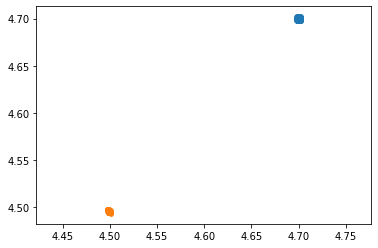

In [118]:
dim = 6
device = torch.device("cpu")
net.to(device)
lowerCoordinate = torch.Tensor([4.6975, 4.6975, 2.9975, 0.9499, -0.0001, -0.0001]).to(device)
upperCoordinate = torch.Tensor([4.7025, 4.7025 ,3.0025, 0.9501,  0.0001,  0.0001 ]).to(device)
inputData = (upperCoordinate - lowerCoordinate) * torch.rand(1000, dim, device=device) \
                                                        + lowerCoordinate
plt.scatter(inputData[:, 0], inputData[:, 1], marker='.', label='Initial', alpha=0.5)
outputData = net(inputData).detach().cpu().numpy()
if lastDim == 3:
    outputData = (A @ inputData.detach().cpu().numpy().T + B @ outputData.T + C).T
plt.scatter(outputData[:, 0], outputData[:, 1], marker='.', label='Initial', alpha=0.5)
plt.axis("equal")

In [8]:
net[0].weight.shape

torch.Size([16, 4])

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

lastDim = 2
net = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, lastDim))

net.to(device)
net.load_state_dict(torch.load("tempBestStateDict.pth"))

In [ ]:
trainCompleteLoop = True

In [7]:
print("best loss: ", bestLoss)
net.load_state_dict(bestStateDict)
layers = []
dimensions = [net[0].weight.shape[1]]
# for i in range(len(net)):
#     if i % 2 == 0:
#         dimensions.append(net[i].weight.shape[0])
# for i in range(len(dimensions) - 1):
#     layers.append(nn.Linear(dimensions[i], dimensions[i + 1]))
#     if i < len(dimensions) - 2:
#         layers.append(nn.ReLU())
# network = nn.Sequential(*layers)
networkClass = NeuralNetwork("../randomNetwork.pth")

networkClass.Linear = net
if trainCompleteLoop:
    print("1")
    torch.save(networkClass.state_dict(), "../quadRotorFullLoopV1.9.pth")
else:
    print("2")
    # torch.save(networkClass.state_dict(), "../quadRotorNormalV1.6.pth")
    torch.save(networkClass.state_dict(), "../fourDimV1.0.pth")

best loss:  tensor(3.81713825e-08, device='cuda:0', grad_fn=<AddBackward0>)
2


In [20]:
weights = []
biases = []
for i in range(len(net)):
    if i % 2 == 0:
        weights.append(net[i].weight.clone().detach().cpu().numpy())
        biases.append(net[i].bias.clone().detach().cpu().unsqueeze(1).numpy())
torch.save({"biases": biases, "weights": weights, "AMatrix": A, "BMatrix": B}, "../fourDimV1.0.pth")

In [ ]:
plt.plot(trainLosses)
plt.plot([validationLoss.item() for validationLoss in validationLosses])
plt.legend(["train loss", "validation loss"])

In [9]:
print("best loss: ", bestLoss)
net.load_state_dict(bestStateDict)
layers = []
dimensions = [net[0].weight.shape[1]]
# for i in range(len(net)):
#     if i % 2 == 0:
#         dimensions.append(net[i].weight.shape[0])
# for i in range(len(dimensions) - 1):
#     layers.append(nn.Linear(dimensions[i], dimensions[i + 1]))
#     if i < len(dimensions) - 2:
#         layers.append(nn.ReLU())
# network = nn.Sequential(*layers)
networkClass = NeuralNetwork("../randomNetwork.pth")

networkClass.Linear = net
if trainCompleteLoop:
    torch.save(networkClass.state_dict(), "../quadRotorFullLoopV1.1.pth")
else:
    torch.save(networkClass.state_dict(), "../quadRotorNormalV1.1.pth")

In [ ]:
plt.plot(trainLosses)
plt.plot([validationLoss.item() for validationLoss in validationLosses])
plt.legend(["train loss", "validation loss"])

7

(11457, 6)